In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(output_folder, 'dynamic.h5'))

# Rank TFs unbiasedly based on their expression and regulation curve chars

# Get the top genes of TF subnetworks based on the beta curve chars

In [10]:
# load ranked TFs list 
ranked_tfs_pb = pd.read_csv(os.path.join(output_folder, 'ranked_tfs_pb.csv'))
pb_top_tfs = ranked_tfs_pb[0:15]
#convert to list of TF_name
pb_top_tfs_list = pb_top_tfs['TF_name'].tolist()
# get tf_indices from pb_top_tfs_list
tf_indices_top_pb_tfs, _, _ = get_tf_indices(dictys_dynamic_object, pb_top_tfs_list)
display(tf_indices_top_pb_tfs)
display(pb_top_tfs_list)

[225, 305, 25, 150, 243, 251, 299, 303, 68, 36, 48, 133, 46, 118, 134]

['PRDM1',
 'XBP1',
 'BHLHE41',
 'MBNL2',
 'RUNX2',
 'SOX2',
 'TP73',
 'VDR',
 'ESR1',
 'CREB3L2',
 'E2F2',
 'KLF2',
 'DPF3',
 'IRF4',
 'KLF3']

In [7]:
# get the edge strengths of the top tfs with all relevant genes (dropping genes based on sparsity)
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

In [32]:
subnetworks_bin = dnetbin[np.ix_(tf_indices_top_pb_tfs, range(dnetbin.shape[1]), range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(15, 11907, 100)

In [33]:
# Calculate sparsity for each gene (across all TFs and timepoints)
# Mean across TFs (axis 0) and time (axis 2)
gene_density = (subnetworks_bin != 0).mean(axis=(0, 2))  # Shape: (11907,)
# Keep genes that are non-zero more than 20% of the time
genes_to_keep = gene_density > 0.05
genes_to_keep_indices = np.where(genes_to_keep)[0]
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get gene names for kept indices directly
kept_target_names = [index_to_gene[idx] for idx in genes_to_keep_indices]
print(len(genes_to_keep_indices))

647


In [29]:
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [30]:
# Filter the subnetworks array to keep only non-sparse genes
filtered_subnetworks = dnet[np.ix_(tf_indices_top_pb_tfs,genes_to_keep_indices, range(dnet.shape[2]))]
print(filtered_subnetworks.shape)

(15, 647, 100)


In [34]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in pb_top_tfs_list for target in kept_target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
betas_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(betas_dcurve.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF    Target                                                               
PRDM1 ABCC1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      ACADM   0.022965  0.023116  0.023237  0.023335  0.023417  0.023492   
      ACADVL -0.000126 -0.000105 -0.000087 -0.000072 -0.000058 -0.000047   
      ACAP1  -0.001366 -0.001227 -0.001097 -0.000975 -0.000863 -0.000759   
      ACAT2   0.002176  0.002328  0.002477  0.002622  0.002761  0.002893   

                time_6    time_7    time_8    time_9  ...       time_90  \
TF    Target                                          ...                 
PRDM1 ABCC1   0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
      ACADM   0.023570  0.023663  0.023781  0.023938  ...  8.242913e-02   
      ACADVL -0.000037 -0.000029 -0.000022 -0.000017  ...  2.175080e-18   
      ACAP1  -0.000665 -0.000579 -0.000502 -0.000434  ... -1.034296e-17   
      ACAT2   0.003016  0.003128  0.003229  0.003318  ...  1.137932e-10   

                   time_91       time_92       time_93       time_94  \
TF    Target                                                           
PRDM1 ABCC1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      ACADM   8.101511e-02  7.948645e-02  7.785483e-02  7.613230e-02   
      ACADVL  1.180057e-18  6.384289e-19  3.444578e-19  1.853553e-19   
      ACAP1  -5.570750e-18 -2.992482e-18 -1.603353e-18 -8.569104e-19   
      ACAT2   7.304838e-11  4.676898e-11  2.986679e-11  1.902533e-11   

                   time_95       time_96       time_97       time_98  \
TF    Target                                                           
PRDM1 ABCC1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      ACADM   7.433100e-02  7.246304e-02  7.054028e-02  6.857421e-02   
      ACADVL  9.948320e-20  5.325988e-20  2.844365e-20  1.515421e-20   
      ACAP1  -4.568560e-19 -2.429902e-19 -1.289409e-19 -6.826717e-20   
      ACAT2   1.208974e-11  7.664277e-12  4.847544e-12  3.059112e-12   

                   time_99  
TF    Target                
PRDM1 ABCC1   0.000000e+00  
      ACADM   6.657586e-02  
      ACADVL  8.055118e-21  
      ACAP1  -3.606439e-20  
      ACAT2   1.926275e-12  

[5 rows x 100 columns]

In [36]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math
from tqdm import tqdm

def process_chunk(args):
    """Process a chunk of curves to compute characteristics"""
    chunk_df, dtime = args
    results = {}
    for idx in chunk_df.index:
        curve = chunk_df.loc[idx]
        char_dict = compute_curve_characteristics(pd.DataFrame(curve).T, dtime)
        results[idx] = char_dict.iloc[0]
    return pd.DataFrame.from_dict(results, orient='index')

# Split data into chunks
n_cores = 8  # Adjust based on your CPU
chunk_size = math.ceil(len(betas_dcurve) / n_cores)
chunks = []

for i in range(0, len(betas_dcurve), chunk_size):
    chunk = betas_dcurve.iloc[i:i + chunk_size]
    chunks.append((chunk, dtime))

# Process chunks in parallel with progress bar
with Pool(n_cores) as pool:
    results = list(tqdm(
        pool.imap(process_chunk, chunks),
        total=len(chunks),
        desc="Processing curves"
    ))

# Combine results and sort
final_dchar = pd.concat(results).sort_index()
final_dchar.to_csv(os.path.join(output_folder, 'betas_chars_15_647.csv'))


Processing curves: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


In [62]:
display(final_dchar.head())

Terminal logFC  Transient logFC  Switching time
BHLHE41 ABCC1         0.000000         0.000000        0.000000
        ACADM         0.000000         0.000000        0.000000
        ACADVL        0.061963        -0.027798        0.926312
        ACAP1         0.155953        -0.012183        0.567255
        ACAT2        -0.066738        -0.014691        0.466751

In [38]:
def get_top_curves_by_category(dchar, ntops=(20,20,30,30)):
    """
    Get top curves for different patterns based on Terminal and Transient logFC.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with curve characteristics, having multi-index (TF, Target)
        and columns ['Terminal logFC', 'Transient logFC', 'Switching time']
    ntops : tuple
        Number of top curves to return for (activating, inactivating, transient_up, transient_down)
    """
    categories = {}
    
    # Activating (positive Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=False).head(ntops[0])
    categories['activating'] = t1.sort_values('Switching time')
    
    # Inactivating (negative Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=True).head(ntops[1])
    categories['inactivating'] = t1.sort_values('Switching time')
    
    # Transient up
    t1 = dchar.sort_values('Transient logFC', ascending=False).head(ntops[2])
    categories['transient_up'] = t1
    
    # Transient down
    t1 = dchar.sort_values('Transient logFC', ascending=True).head(ntops[3])
    categories['transient_down'] = t1
    
    # Extract TF-target pairs for each category
    activating_pairs = [(idx[0], idx[1]) for idx in categories['activating'].index]
    inactivating_pairs = [(idx[0], idx[1]) for idx in categories['inactivating'].index]
    transient_up_pairs = [(idx[0], idx[1]) for idx in categories['transient_up'].index]
    transient_down_pairs = [(idx[0], idx[1]) for idx in categories['transient_down'].index]
    
    return {
        'activating': activating_pairs,
        'inactivating': inactivating_pairs,
        'transient_up': transient_up_pairs,
        'transient_down': transient_down_pairs
    }

In [39]:
sorted_categories = get_top_curves_by_category(final_dchar, ntops=(20,20,30,30))

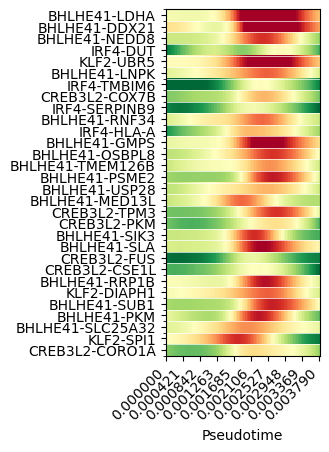

In [46]:
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=sorted_categories['transient_down'],
    num=100,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [47]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in sorted_categories['transient_down']])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.45411423323397027 to 0.28250742483385227


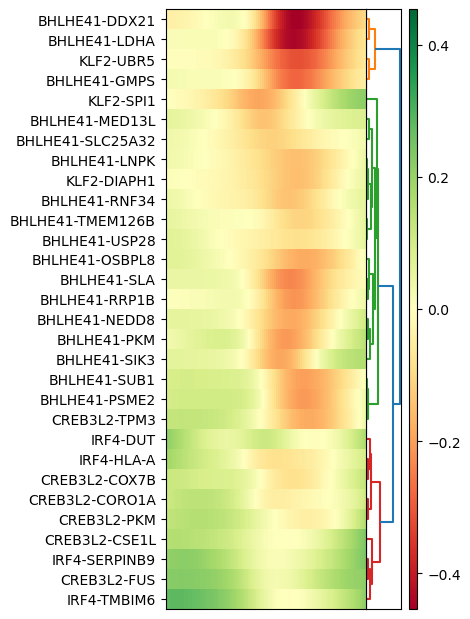

In [48]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

In [61]:
# extarct gene names for pathway analysis
row_labels = df.index
# Extract just the target names from the TF-target pairs
target_names = [pair.split('-')[1] for pair in row_labels]
unique_targets = sorted(set(target_names)) 
print(target_names)

['LDHA', 'DDX21', 'NEDD8', 'DUT', 'UBR5', 'LNPK', 'TMBIM6', 'COX7B', 'SERPINB9', 'RNF34', 'HLA', 'GMPS', 'OSBPL8', 'TMEM126B', 'PSME2', 'USP28', 'MED13L', 'TPM3', 'PKM', 'SIK3', 'SLA', 'FUS', 'CSE1L', 'RRP1B', 'DIAPH1', 'SUB1', 'PKM', 'SLC25A32', 'SPI1', 'CORO1A']


# Geneset regulatory activity

In [91]:
def read_gmt_file(gmt_path):
    """
    Read a GMT file and return a dictionary of gene sets.
    
    Parameters:
    -----------
    gmt_path : str
        Path to the GMT file
        
    Returns:
    --------
    dict : Dictionary with gene set names as keys and gene lists as values
    """
    gene_sets = {}
    with open(gmt_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            # First field is name, second is description (we'll skip it)
            name = parts[0]
            # Remaining fields are genes
            genes = [g.upper() for g in parts[2:]]  # Convert to uppercase
            gene_sets[name] = genes
    
    return gene_sets

In [96]:
# Load the GMT file
kegg_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/KEGG_CELL_CYCLE.v2024.1.Hs.gmt'
gobp_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/GOBP_CELL_CYCLE.v2024.1.Hs.gmt'
phase_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/CELL_CYCLE_PHASE.v2024.1.Hs.gmt'
# create a list of genes from the dicts
cell_cycle_kegg_genes = list(read_gmt_file(kegg_gmt_file)['KEGG_CELL_CYCLE'])
cell_cycle_gobp_genes = list(read_gmt_file(gobp_gmt_file)['GOBP_CELL_CYCLE'])
cell_cycle_phase_genes = list(read_gmt_file(phase_gmt_file)['CELL_CYCLE_PHASE'])
display(len(cell_cycle_kegg_genes))
display(len(cell_cycle_gobp_genes))
display(len(cell_cycle_phase_genes))


125

1684

170

In [14]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'

# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)

# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()

# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))


In [15]:
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 68 genes
Missing 0 genes
Indices: {'ELL2': 2979, 'BTG2': 1106, 'JCHAIN': 4730, 'SEL1L3': 8763, 'TRAM2': 10473, 'HLA-DRB1': 4201, 'CTSH': 2270, 'FNDC3A': 3516, 'HLA-C': 4189, 'PIKFYVE': 7235, 'UBAC2': 10759, 'FNDC3B': 3517, 'PRDM1': 7604, 'PDE4D': 7027, 'ANKRD28': 429, 'LMAN1': 5269, 'SLA': 8982, 'HSP90B1': 4304, 'CEP128': 1733, 'CDK6': 1665, 'HLA-DMB': 4191, 'HLA-A': 4187, 'CCSER2': 1534, 'MZB1': 6199, 'ARFGAP3': 560, 'HLA-DPB1': 4195, 'CD52': 1574, 'GAB1': 3613, 'CD74': 1586, 'TBC1D4': 9887, 'CIITA': 1884, 'SSR1': 9582, 'CPEB4': 2131, 'EEA1': 2862, 'HM13': 4210, 'MAPK1': 5543, 'PPIB': 7507, 'MED23': 5675, 'SLAMF7': 8987, 'TNFAIP8': 10337, 'PAX5': 6943, 'SLC25A13': 9042, 'HLA-DQB1': 4198, 'CD99': 1598, 'DEK': 2479, 'MAN1A1': 5488, 'TIAM1': 10070, 'HLA-DRA': 4200, 'B2M': 872, 'IRF4': 4652, 'TXNDC5': 10727, 'RUNX2': 8586, 'HLA-B': 4188, 'IQGAP2': 4638, 'SUB1': 9706, 'TRAM1': 10472, 'RNF213': 8355, 'TXNDC11': 10722, 'HLA-DMA': 4190, 'IGHM': 4421, 'GLCCI1': 3767, 'PIM2': 7239, 'HLA-D

In [99]:
kegg_cell_cycle_in_object = check_if_gene_in_ndict(dictys_dynamic_object, cell_cycle_kegg_genes, return_index=True)
print(f"Found {len(kegg_cell_cycle_in_object['present'])} genes")
print(f"Missing {len(kegg_cell_cycle_in_object['missing'])} genes")
print("Indices:", kegg_cell_cycle_in_object['indices'])
# create a list of genes that are in the object from te indices dict keys
kegg_cell_cycle_genes = list(kegg_cell_cycle_in_object['indices'].keys())
display(len(kegg_cell_cycle_genes))
# get lcpm chars for these genes

Found 118 genes
Missing 7 genes
Indices: {'ABL1': 69, 'ANAPC1': 385, 'ANAPC10': 386, 'ANAPC11': 387, 'ANAPC13': 388, 'ANAPC2': 391, 'ANAPC4': 392, 'ANAPC5': 393, 'ANAPC7': 394, 'ATM': 766, 'ATR': 841, 'BUB1': 1116, 'BUB1B': 1117, 'BUB3': 1118, 'CCNA2': 1498, 'CCNB1': 1499, 'CCNB2': 1501, 'CCND1': 1503, 'CCND2': 1504, 'CCND3': 1506, 'CCNE1': 1508, 'CCNE2': 1509, 'CCNH': 1513, 'CDC14A': 1603, 'CDC14B': 1604, 'CDC16': 1605, 'CDC20': 1606, 'CDC23': 1607, 'CDC25A': 1608, 'CDC25B': 1609, 'CDC25C': 1610, 'CDC26': 1611, 'CDC27': 1612, 'CDC45': 1626, 'CDC6': 1628, 'CDC7': 1629, 'CDK1': 1647, 'CDK2': 1657, 'CDK4': 1660, 'CDK6': 1665, 'CDK7': 1666, 'CDKN1A': 1673, 'CDKN1B': 1674, 'CDKN1C': 1675, 'CDKN2A': 1676, 'CDKN2C': 1680, 'CDKN2D': 1681, 'CHEK1': 1826, 'CHEK2': 1827, 'CREBBP': 2168, 'CUL1': 2279, 'DBF4': 2369, 'E2F1': 2816, 'E2F2': 2817, 'E2F3': 2818, 'E2F4': 2819, 'E2F5': 2820, 'EP300': 3053, 'ESPL1': 3132, 'FZR1': 3604, 'GADD45A': 3628, 'GADD45B': 3629, 'GADD45G': 3630, 'GSK3B': 3979, 'HDA

118

## Expression dynamics of the genes

In [16]:
# get lcpm chars for these genes
dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = dcurve_pb.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
display(lf_lcpm_dchar_pb)

,Terminal logFC,Transient logFC,Switching time
ELL2,2.088328,-0.020260,0.513633
BTG2,0.514419,0.000000,0.453747
JCHAIN,5.354033,0.000000,0.417039
SEL1L3,2.035248,0.000000,0.391846
TRAM2,3.661848,0.000000,0.427215
...,...,...,...
ARNTL2,-0.477917,-0.035726,0.335514
CD79A,1.037063,0.000000,0.323713
HLA-DPA1,-0.079617,0.040049,0.615333
XBP1,3.304020,0.000000,0.480034


In [17]:
# get lcpm chars for these genes
dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = dcurve_gc.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_gc = compute_curve_characteristics(lf_lcpm_dcurve_gc, dtime_gc)
display(lf_lcpm_dchar_gc)

,Terminal logFC,Transient logFC,Switching time
ELL2,-0.112707,0.193590,0.832172
BTG2,-1.373469,-0.022837,0.391862
JCHAIN,2.225792,0.004013,0.263106
SEL1L3,0.663169,0.000000,0.564570
TRAM2,1.070001,0.123893,0.225932
...,...,...,...
ARNTL2,1.211005,0.002363,0.385570
CD79A,-0.043852,-0.008808,0.212825
HLA-DPA1,-0.133873,-0.003303,0.394366
XBP1,0.878915,0.010232,0.290158


#### Choosing the genes which are dynamically divergent in lineages from the LFs

In [18]:
def find_dynamically_opposite_genes(gc_dchar: pd.DataFrame, pb_dchar: pd.DataFrame, min_effect: float = 0.1):
    """
    Find genes with opposite effects between GC and PB lineages by:
    1. Filtering out low effect genes
    2. Normalizing metrics within each condition separately
    3. Finding dominant effect (Terminal/Transient) for each gene in each condition
    4. Comparing signs of dominant effects
    
    Parameters:
    -----------
    gc_dchar, pb_dchar : pd.DataFrame
        DataFrames with 'Terminal logFC' and 'Transient logFC' columns
    min_effect : float
        Minimum absolute effect size threshold for filtering
    
    Returns:
    --------
    list : List of genes with opposite dominant effects between conditions
    """
    # Filter genes with low effect sizes in both conditions
    gc_filtered = gc_dchar[
        (abs(gc_dchar['Terminal logFC']) >= min_effect) | 
        (abs(gc_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    pb_filtered = pb_dchar[
        (abs(pb_dchar['Terminal logFC']) >= min_effect) | 
        (abs(pb_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    # Get common genes after filtering
    common_genes = list(set(gc_filtered.index) & set(pb_filtered.index))
    gc_filtered = gc_filtered.loc[common_genes]
    pb_filtered = pb_filtered.loc[common_genes]
    
    # Create normalized versions
    gc_norm = gc_filtered.copy()
    pb_norm = pb_filtered.copy()
    
    # Normalize GC metrics
    gc_terminal_abs = np.abs(gc_filtered['Terminal logFC'])
    gc_terminal_min = gc_terminal_abs.min()
    gc_terminal_max = gc_terminal_abs.max()
    gc_norm['Terminal logFC'] = (gc_terminal_abs - gc_terminal_min) / (gc_terminal_max - gc_terminal_min)
    gc_norm['Terminal logFC'] *= np.sign(gc_filtered['Terminal logFC'])
    
    gc_transient_abs = np.abs(gc_filtered['Transient logFC'])
    gc_transient_min = gc_transient_abs.min()
    gc_transient_max = gc_transient_abs.max()
    gc_norm['Transient logFC'] = (gc_transient_abs - gc_transient_min) / (gc_transient_max - gc_transient_min)
    gc_norm['Transient logFC'] *= np.sign(gc_filtered['Transient logFC'])
    
    # Normalize PB metrics
    pb_terminal_abs = np.abs(pb_filtered['Terminal logFC'])
    pb_terminal_min = pb_terminal_abs.min()
    pb_terminal_max = pb_terminal_abs.max()
    pb_norm['Terminal logFC'] = (pb_terminal_abs - pb_terminal_min) / (pb_terminal_max - pb_terminal_min)
    pb_norm['Terminal logFC'] *= np.sign(pb_filtered['Terminal logFC'])
    
    pb_transient_abs = np.abs(pb_filtered['Transient logFC'])
    pb_transient_min = pb_transient_abs.min()
    pb_transient_max = pb_transient_abs.max()
    pb_norm['Transient logFC'] = (pb_transient_abs - pb_transient_min) / (pb_transient_max - pb_transient_min)
    pb_norm['Transient logFC'] *= np.sign(pb_filtered['Transient logFC'])
    
    opposite_genes = []
    
    # Compare dominant effects for each gene
    for idx in common_genes:
        # Get normalized values
        gc_terminal = gc_norm.at[idx, 'Terminal logFC']
        gc_transient = gc_norm.at[idx, 'Transient logFC']
        pb_terminal = pb_norm.at[idx, 'Terminal logFC']
        pb_transient = pb_norm.at[idx, 'Transient logFC']
        
        # Determine dominant effect for each condition
        gc_dominant_val = gc_terminal if abs(gc_terminal) >= abs(gc_transient) else gc_transient
        pb_dominant_val = pb_terminal if abs(pb_terminal) >= abs(pb_transient) else pb_transient
        
        # Check if dominant effects have opposite signs
        if gc_dominant_val * pb_dominant_val < 0:
            opposite_genes.append(idx)
    return opposite_genes


In [19]:
opposite_genes = find_dynamically_opposite_genes(lf_lcpm_dchar_gc, lf_lcpm_dchar_pb, min_effect=0.3)
display(len(opposite_genes))

21

In [20]:
# order the opposite genes by keeping the upregulated genes first then downregulated genes
opposite_genes_ordered_pb = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Terminal logFC'], reverse=True)
opposite_genes_ordered_gc = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Terminal logFC'], reverse=True)


#### Genes with the most significant effect size changes per lineage

In [21]:
def get_top_terminal_effect_genes(dchar: pd.DataFrame, n_top: int = 15):
    """
    Get top genes based on their normalized effect sizes.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with 'Terminal logFC' and 'Transient logFC' columns
    n_top : int
        Number of top genes to return
    
    Returns:
    --------
    list : List of top genes sorted by combined normalized effect size
    """
    # Create normalized version of the dataframe
    norm_dchar = dchar.copy()
    
    # Normalize Terminal logFC
    terminal_abs = np.abs(dchar['Terminal logFC'])
    terminal_min = terminal_abs.min()
    terminal_max = terminal_abs.max()
    norm_dchar['Terminal logFC'] = (terminal_abs - terminal_min) / (terminal_max - terminal_min)
        
    # Sort by combined effect and get top genes
    top_genes = norm_dchar.nlargest(n_top, 'Terminal logFC').index.tolist()
    
    print(f"Top {n_top} genes by effect size:")
    for i, gene in enumerate(top_genes, 1):
        effect = norm_dchar.at[gene, 'Terminal logFC']
        print(f"{i}. {gene}: {effect:.3f}")
    
    return top_genes

In [22]:
# Usage:
top_pb_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_pb, n_top=10)
top_gc_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_gc, n_top=10)

Top 10 genes by effect size:
1. JCHAIN: 1.000
2. AFF3: 0.887
3. PRDM1: 0.859
4. FNDC3B: 0.822
5. TRAM2: 0.681
6. MZB1: 0.675
7. IGHM: 0.638
8. XBP1: 0.614
9. TXNDC5: 0.611
10. TXNDC11: 0.604
Top 10 genes by effect size:
1. JCHAIN: 1.000
2. MED23: 0.685
3. SLAMF7: 0.676
4. BTG2: 0.617
5. TBC1D4: 0.612
6. CD52: 0.609
7. PIM2: 0.576
8. ARNTL2: 0.544
9. RUNX2: 0.515
10. FNDC3B: 0.498


In [23]:
# take a union of top_genes and opposite_genes
dynamic_pb_genes = list(set(top_pb_genes + opposite_genes))
dynamic_gc_genes = list(set(top_gc_genes + opposite_genes))
display(len(dynamic_pb_genes))
display(len(dynamic_gc_genes))


30

24

In [24]:
# order the dynamic_pb_genes by the switching time
dynamic_pb_genes_ordered = sorted(dynamic_pb_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Switching time'])
dynamic_gc_genes_ordered = sorted(dynamic_gc_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Switching time'])

#### Classification of genes by expression dynamics

In [141]:
lf_classifications, percentiles_used = classify_genes_by_expression_dynamics(lf_lcpm_dchar_pb, ntops=(25, 5, 7, 5))

print("\nEffective percentiles used:")
for category, percentile in percentiles_used.items():
    if percentile is not None:
        print(f"{category}: {percentile:.1f}%")
for category, genes in lf_classifications.items():
    print(f"{category}: {len(genes)} genes")


Effective percentiles used:
up_regulated: 34.2%
transient_up: 37.5%
down_regulated: 58.8%
transient_down: 0.0%
up_regulated: 25 genes
transient_up: 5 genes
down_regulated: 7 genes
transient_down: 5 genes


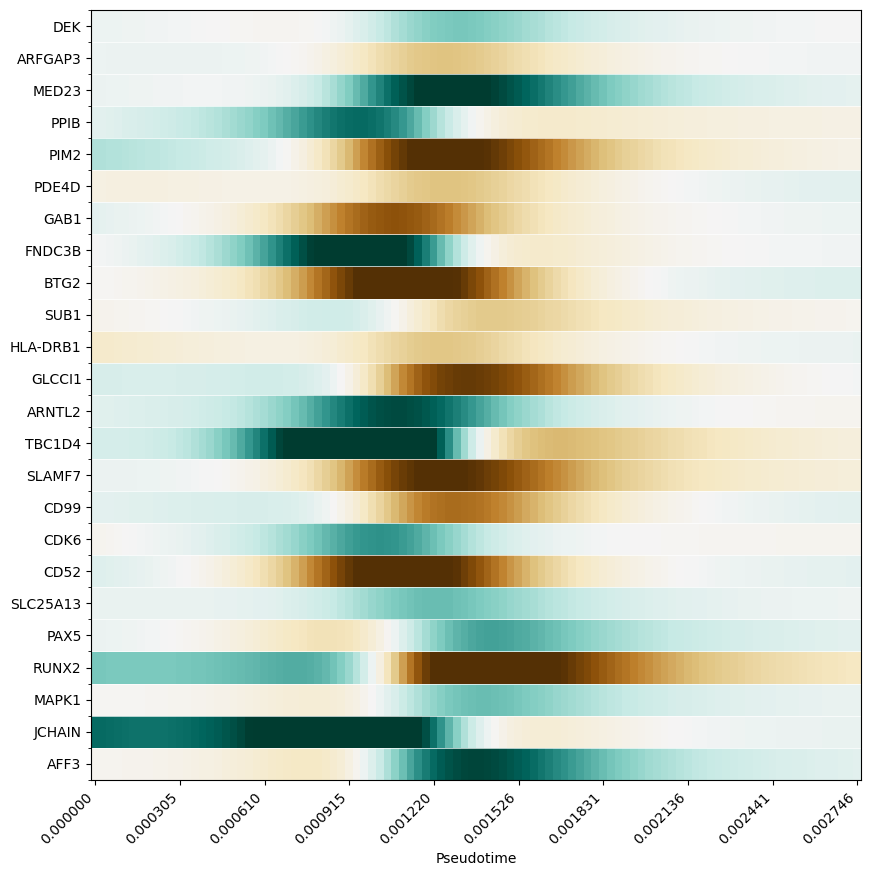

In [204]:
# Create figure for up-regulated genes
fig, ax = plt.subplots(figsize=(10, 10))
# Get genes from the up_regulated category
#transient_down_genes = lf_classifications['transient_down']
# Plot expression gradient for up-regulated genes
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=dynamic_gc_genes,
    num=100,
    dist=0.0005,
    ax=ax,
    cmap="BrBG",
    figsize=(10, 0.3)
)

In [134]:
# combine the genes from the classifications into one filtered list
filtered_lf_genes = list(lf_classifications['up_regulated']) + list(lf_classifications['transient_up']) + list(lf_classifications['down_regulated']) + list(lf_classifications['transient_down'])

/tmp/ipykernel_7446/3425436304.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


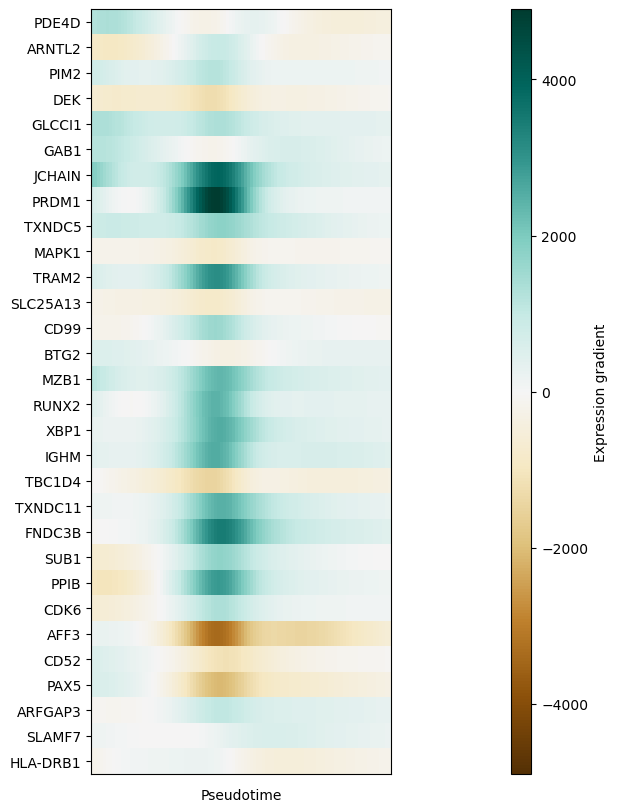

In [205]:
fig, gradients, ordered_genes = fig_clustered_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    genes_or_regulations=dynamic_pb_genes,
    dchar=lf_lcpm_dchar_pb,
    num=100,
    dist=0.0005,
    cmap='BrBG'
)

## Regulations and beta characteristics

#### Get subnetworks for the dynamic genes in PB lineage

In [9]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)

In [11]:
dnet = stat1_net.compute(pts)

In [12]:
display(dnetbin.shape)

(551, 11907, 100)

In [25]:
# get indices of the dynamic_pb_genes
dynamic_pb_genes_indices = get_gene_indices(dictys_dynamic_object, dynamic_pb_genes)
display(len(dynamic_pb_genes_indices))  

30

In [26]:
subnetworks_bin = dnetbin[np.ix_(range(dnetbin.shape[0]), dynamic_pb_genes_indices, range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(551, 30, 100)

#### Can filter TFs from the entire list (551)

In [218]:
# Calculate sparsity for each TF (across all genes and timepoints)
TF_density = (subnetworks_bin != 0).mean(axis=(1, 2))
# Keep TFs that are non-zero more than x% of the time
TFs_to_keep = TF_density > 0.1
TFs_to_keep_indices = np.where(TFs_to_keep)[0]

# Get TF names
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
TFs_to_keep_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in TFs_to_keep_indices]
kept_tf_names = [index_to_gene[idx] for idx in TFs_to_keep_gene_indices]
print(len(kept_tf_names))

26


#### Or use the pre-ranked TFs in the lineage

In [27]:
# Get the subnetworks for the kept TFs
filtered_subnetworks = dnet[np.ix_(tf_indices_top_pb_tfs, dynamic_pb_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(15, 30, 100)

#### Get beta dchars for a lineage


In [28]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in pb_top_tfs_list for target in dynamic_pb_genes]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
betas_dcurve_pb = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(betas_dcurve_pb.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF    Target                                                                 
PRDM1 BTG2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      JCHAIN    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      TRAM2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      HLA-DRB1  0.089233  0.091142  0.092755  0.094060  0.095045  0.095706   
      PDE4D    -0.008808 -0.009285 -0.009750 -0.010199 -0.010628 -0.011032   

                  time_6    time_7    time_8    time_9  ...       time_90  \
TF    Target                                            ...                 
PRDM1 BTG2      0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
      JCHAIN    0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
      TRAM2     0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
      HLA-DRB1  0.096044  0.096062  0.095772  0.095185  ... -6.845944e-02   
      PDE4D    -0.011409 -0.011756 -0.012070 -0.012348  ... -2.023821e-09   

                     time_91       time_92       time_93       time_94  \
TF    Target                                                             
PRDM1 BTG2      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      JCHAIN    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      TRAM2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      HLA-DRB1 -6.799425e-02 -6.746147e-02 -6.686332e-02 -6.620188e-02   
      PDE4D    -1.335506e-09 -8.790213e-10 -5.771148e-10 -3.779750e-10   

                     time_95       time_96       time_97       time_98  \
TF    Target                                                             
PRDM1 BTG2      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      JCHAIN    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      TRAM2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      HLA-DRB1 -6.547920e-02 -6.469733e-02 -6.385837e-02 -6.296449e-02   
      PDE4D    -2.469620e-10 -1.609870e-10 -1.047060e-10 -6.795147e-11   

                     time_99  
TF    Target                  
PRDM1 BTG2      0.000000e+00  
      JCHAIN    0.000000e+00  
      TRAM2     0.000000e+00  
      HLA-DRB1 -6.201800e-02  
      PDE4D    -4.400461e-11  

[5 rows x 100 columns]

In [32]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math
from tqdm import tqdm

def process_chunk(args):
    """Process a chunk of curves to compute characteristics"""
    chunk_df, dtime = args
    results = {}
    for idx in chunk_df.index:
        curve = chunk_df.loc[idx]
        char_dict = compute_curve_characteristics(pd.DataFrame(curve).T, dtime)
        results[idx] = char_dict.iloc[0]
    return pd.DataFrame.from_dict(results, orient='index')

# Split data into chunks
n_cores = 8  # Adjust based on your CPU
chunk_size = math.ceil(len(betas_dcurve_pb) / n_cores)
chunks = []

for i in range(0, len(betas_dcurve_pb), chunk_size):
    chunk = betas_dcurve_pb.iloc[i:i + chunk_size]
    chunks.append((chunk, dtime))

# Process chunks in parallel with progress bar
with Pool(n_cores) as pool:
    results = list(tqdm(
        pool.imap(process_chunk, chunks),
        total=len(chunks),
        desc="Processing curves"
    ))

# Combine results and sort
final_dchar_pb = pd.concat(results).sort_index()
final_dchar_pb.to_csv(os.path.join(output_folder, 'betas_chars_pb_15_30.csv'))


Processing curves: 100%|██████████| 8/8 [00:00<00:00, 96.12it/s]


In [33]:
# # load the final_dchar_pb
# final_dchar_pb = pd.read_csv(os.path.join(output_folder, 'betas_chars_pb_15_30.csv'), index_col=0)
display(final_dchar_pb.head())
display(final_dchar_pb.shape)

Terminal logFC  Transient logFC  Switching time
BHLHE41 AFF3           0.000000         0.000000        0.000000
        ARFGAP3        0.000000         0.000000        0.000000
        ARNTL2         0.000000         0.000000        0.000000
        BTG2          -0.023897        -0.005308        0.072839
        CD52          -0.024763         0.003664        0.517399

(450, 3)

#### Normalize the beta dchars over the entire geneset for the lineage

In [34]:
def normalize_and_rank_regulations(df):
    """
    Normalize regulations to [-1, 1] scale and rank by absolute effect size.
    """
    # Create copy
    df_norm = df.copy()
    
    # Normalize Terminal logFC to [-1, 1]
    terminal_max = max(abs(df['Terminal logFC'].min()), abs(df['Terminal logFC'].max()))
    df_norm['norm_Terminal'] = df['Terminal logFC'] / terminal_max if terminal_max != 0 else 0
    
    # Normalize Transient logFC to [-1, 1]
    transient_max = max(abs(df['Transient logFC'].min()), abs(df['Transient logFC'].max()))
    df_norm['norm_Transient'] = df['Transient logFC'] / transient_max if transient_max != 0 else 0
    
    # Get maximum absolute effect (for ranking)
    df_norm['max_abs_effect'] = df_norm[['norm_Terminal', 'norm_Transient']].abs().max(axis=1)
    
    # Rank based on absolute effect size
    df_norm['regulation_rank'] = df_norm['max_abs_effect'].rank(ascending=False)
    
    # Sort by rank
    df_norm = df_norm.sort_values('regulation_rank')
    return df_norm

def get_top_regulations(df, n_top=10, effect_type='positive'):
    """
    Get top positive, negative, or all regulations based on normalized effect size.
    """
    if effect_type == 'positive':
        mask = (df['norm_Terminal'] > 0) | (df['norm_Transient'] > 0)
    elif effect_type == 'negative':
        mask = (df['norm_Terminal'] < 0) | (df['norm_Transient'] < 0)
    else:
        mask = slice(None)
        
    filtered_df = df[mask] if effect_type != 'all' else df
    top_regs = filtered_df.nlargest(n_top, 'max_abs_effect')
    return top_regs

In [35]:
normalized_dchar_pb = normalize_and_rank_regulations(final_dchar_pb)
# Get top positive regulations
top_positive_pb = get_top_regulations(normalized_dchar_pb, n_top=20, effect_type='positive')

In [42]:
# Standard scientific Python imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def cluster_regulations_by_time(df, n_clusters=3):
    """
    Cluster regulations by switching time and return TF-target tuples per cluster.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with multi-index (TF, target) and 'Switching time' column
    n_clusters : int
        Number of clusters to create
    
    Returns:
    --------
    dict : Dictionary of TF-target tuples for each cluster
    """
    # Prepare switching time data for clustering
    X = df['Switching time'].values.reshape(-1, 1)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df = df.copy()
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Sort clusters by their mean switching time
    cluster_means = df.groupby('cluster')['Switching time'].mean()
    cluster_order = cluster_means.sort_values().index
    cluster_map = {old: new for new, old in enumerate(cluster_order)}
    df['cluster'] = df['cluster'].map(cluster_map)
    
    # Create dictionary for results
    cluster_tuples = {}
    
    # Process each cluster
    for i in range(n_clusters):
        cluster_df = df[df['cluster'] == i]
        
        # Get tuples from multi-index
        tuples = [(idx[0], idx[1]) for idx in cluster_df.index if isinstance(idx, tuple)]
        cluster_tuples[f'cluster_{i}'] = tuples
    return cluster_tuples

In [43]:
# Usage:
regulation_clusters = cluster_regulations_by_time(top_positive_pb, n_clusters=3)

# Access tuples for each timing cluster
early_regulations = regulation_clusters['cluster_0']  # Early regulations
mid_regulations = regulation_clusters['cluster_1']    # Mid-time regulations
late_regulations = regulation_clusters['cluster_2']   # Late regulations
display(early_regulations)


[('CREB3L2', 'PRDM1'),
 ('KLF3', 'JCHAIN'),
 ('KLF3', 'PIM2'),
 ('IRF4', 'FNDC3B')]

In [44]:
# join the early, mid, and late regulations lists
top_clustered_regulations_pb = list(early_regulations) + list(mid_regulations) + list(late_regulations)
display(top_clustered_regulations_pb)


[('CREB3L2', 'PRDM1'),
 ('KLF3', 'JCHAIN'),
 ('KLF3', 'PIM2'),
 ('IRF4', 'FNDC3B'),
 ('RUNX2', 'FNDC3B'),
 ('IRF4', 'CDK6'),
 ('BHLHE41', 'PRDM1'),
 ('PRDM1', 'AFF3'),
 ('CREB3L2', 'TXNDC5'),
 ('IRF4', 'HLA-DRB1'),
 ('CREB3L2', 'MZB1'),
 ('KLF2', 'XBP1'),
 ('KLF2', 'PPIB'),
 ('DPF3', 'HLA-DRB1'),
 ('IRF4', 'PDE4D'),
 ('IRF4', 'GAB1'),
 ('KLF2', 'TXNDC11'),
 ('KLF2', 'SUB1'),
 ('PRDM1', 'CD99'),
 ('VDR', 'PPIB')]

In [48]:
top_clustered_regulations_pb = [('BHLHE41', 'PRDM1'),('IRF4', 'CDK6'),('PRDM1', 'AFF3'),('CREB3L2', 'MZB1'),('CREB3L2', 'TXNDC5'),('PRDM1', 'CD99'),('KLF3', 'JCHAIN'),('IRF4', 'FNDC3B'),('VDR', 'PPIB'),('KLF3', 'PIM2'),('CREB3L2', 'PRDM1'),('RUNX2', 'FNDC3B'),('IRF4', 'PDE4D'),('KLF2', 'SUB1'),('KLF2', 'TXNDC11'),('KLF2', 'PPIB'),('IRF4', 'GAB1'),('KLF2', 'XBP1'),('DPF3', 'HLA-DRB1'),('IRF4', 'HLA-DRB1')]

In [ ]:
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=top_clustered_regulations_pb,
    num=100,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [46]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in top_clustered_regulations_pb])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.2761862343716693 to 0.2556626735328473


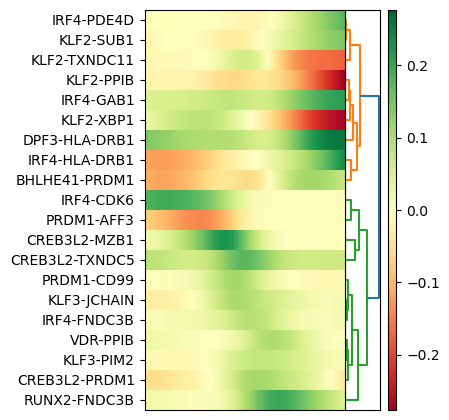

In [47]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value